# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Libraries**</font>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Softmax, RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tqdm import tqdm
import re
import nltk
from datetime import datetime 
tf.config.run_functions_eagerly(True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%load_ext tensorboard

<font color='blue'>**Load the data**</font>

In [4]:
with open('/content/drive/MyDrive/ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(343813, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<font color='blue'>**Preprocess data**</font>

In [5]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [6]:
data.sample(10)

,english,italian
2773,i disagree,non sono daccordo
343499,if you do not want to put on sunscreen that is...,se non vi volete mettere della protezione sola...
73788,i never told anyone,io non lho mai detto a qualcuno
153482,they want to become rich,vogliono diventare ricche
324412,i bought a watch and i lost it the next day,comprai un orologio e lo persi il giorno succe...
284748,what is important is the experience,quello che è importante è lesperienza
3317,is it free,è gratuita
31026,we both laughed,abbiamo entrambe riso
332167,grandmother is ashes are in an urn at the temple,le ceneri della nonna sono in unurna nel tempio
227144,please give me your attention,per piacere mi dia la sua attenzione


In [7]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [8]:
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 21.18800000002375
100 101.0


In [9]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [10]:
data.sample(10)

,italian,english_inp,english_out
236174,io vado alle hawaii lanno prossimo,<start> i am going to hawaii next year,i am going to hawaii next year <end>
72151,anche io sono un maestro,<start> i am a teacher too,i am a teacher too <end>
237405,lo sapevo che oggi sarebbe divertente,<start> i knew that today would be fun,i knew that today would be fun <end>
320499,tom dice che non potrebbe mai vivere in australia,<start> tom says he could never live in australia,tom says he could never live in australia <end>
245054,perché sembrate così preoccupati,<start> why are you looking so worried,why are you looking so worried <end>
192811,ha messo la scatola sul tavolo,<start> he put the box on the table,he put the box on the table <end>
154538,tom spera che ti piaccia,<start> tom hopes you will like it,tom hopes you will like it <end>
126676,chi stai proteggendo,<start> who are you protecting,who are you protecting <end>
126498,dove sono le bambine,<start> where are the children,where are the children <end>
312775,tom mi disturbò con molte domande,<start> tom bothered me with a lot of questions,tom bothered me with a lot of questions <end>


In [11]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [12]:
print(train.shape, validation.shape)
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(274710, 3) (68678, 3)


In [13]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [14]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10128)

In [15]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12854
26208


In [16]:
from tqdm import tqdm
embeddings_index = dict()
f = open('/content/drive/MyDrive/Data/glove.6B.100d.txt','rb')
for line in tqdm(f):
    values = line.split()
    word = re.sub('b\'','',str(values[0]))
    word = word[:-1]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

400000it [00:11, 33921.63it/s]


## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [17]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,enc_units,input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.embedding= Embedding(self.vocab_size,self.embedding_dim,input_length=self.input_length)
        self.lstm     = LSTM(self.enc_units,return_state=True,return_sequences=True)
            

    def call(self, input_sequence, initial_states,training=True):
        embedding          = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(embedding)
        return (self.lstm_output, self.lstm_state_h,self.lstm_state_c)
    

    
    def initialize_states(self,batch_size):
        return (tf.zeros((batch_size,self.enc_units)),tf.zeros((batch_size,self.enc_units)))



<font color='orange'>**Grader function - 1**</font>

In [18]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
  
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [19]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units,input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.input_length = input_length
        self.embedding    = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, name="embedding_layer_decoder", trainable=True)
        self.lstm         = LSTM(self.dec_units,return_state=True,return_sequences=True)

    def call(self, target_sentances, states):
        embedding = self.embedding(target_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(embedding,initial_state=states)
        return (self.lstm_output, self.lstm_state_h,self.lstm_state_c)
        


<font color='orange'>**Grader function - 2**</font>

In [20]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [21]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [22]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


In [23]:
start=tknizer_eng.word_index['<start>']

In [24]:
class Encoder_Decoder(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=vocab_size_ita+1, embedding_dim=50, input_length=encoder_inputs_length, enc_units=256)
        self.encoder.trainable=True
        self.decoder = Decoder(vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=decoder_inputs_length, dec_units=256)
        self.decoder.trainable=True
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
        
    def call(self, data):
        input,output = data[0], data[1]
        initial_state=self.encoder.initialize_states(batch_size)
        encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
        decoder_output,_,_                   = self.decoder(output,states=[encoder_h, encoder_c])
        output                               = self.dense(decoder_output)
        return output

In [25]:
model  = Encoder_Decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
batch_size=1024
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data= test_dataloader, validation_steps=valid_steps,callbacks=tensorboard_callback)
model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
268/268 [==============================] - 126s 468ms/step - loss: 3.4921 - val_loss: 1.6614
Epoch 2/30
268/268 [==============================] - 124s 463ms/step - loss: 1.6072 - val_loss: 1.4633
Epoch 3/30
268/268 [==============================] - 128s 477ms/step - loss: 1.4133 - val_loss: 1.2810
Epoch 4/30
268/268 [==============================] - 127s 474ms/step - loss: 1.2501 - val_loss: 1.1804
Epoch 5/30
268/268 [==============================] - 129s 481ms/step - loss: 1.1367 - val_loss: 1.0677
Epoch 6/30
268/268 [==============================] - 130s 483ms/step - loss: 1.0304 - val_loss: 0.9767
Epoch 7/30
268/268 [==============================] - 130s 486ms/step - loss: 0.9377 - val_loss: 0.8976
Epoch 8/30
268/268 [==============================] - 126s 470ms/step - loss: 0.8543 - val_loss: 0.8227
Epoch 9/30
268/268 [==============================] - 127s 475ms/step - loss: 0.7705 - val_loss: 0.7493
Epoch 10/30
268/268 [==============================] - 128s 476m

In [ ]:
tensorboard --logdir=./

In [27]:
def predict(input_sentence):
 encoded                 = tknizer_ita.texts_to_sequences([input_sentence])
 encoded                 = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=20, dtype='int',padding='post'))
 initial_state           = model.layers[0].initialize_states(batch_size=1)
 encoder_outputs, h , c  = model.layers[0](encoded,initial_state)
 
 start                   = tknizer_eng.word_index['<start>']
 output_sentence=[]
 
 for i in range(20):
   decoder_output, h, c  = model.layers[1](tf.expand_dims([start],axis=1),states=[h ,c])
   dense_output          = model.layers[2](decoder_output)
   word_index            = tf.math.argmax(*dense_output,1)
   english_word          = tknizer_eng.index_word[word_index.numpy()[0]]
   start                 = word_index.numpy()[0]
   output_sentence.append(english_word)

   if english_word=='<end>':
     break
     
 return " ".join(output_sentence)

In [28]:
Bleu=[]
print(len(validation['italian']))

for i in np.random.choice(np.arange(len(validation['italian'])),size=1000,replace=False):
  Bleu.append(nltk.translate.bleu_score.sentence_bleu(validation['english_out'].iloc[i],predict(validation['italian'].iloc[i])))
print(sum(Bleu)/1000)

# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

for i in np.random.choice(np.arange(len(validation['italian'])),size=10,replace=False):
  print('Italian\t',validation['italian'].iloc[i])
  print('English_out\t',validation['english_out'].iloc[i])
  print('Predicted\t',predict(validation['italian'].iloc[i]))
  print('\n')

68678


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.834200935079292
Italian	 posso parlare adesso
English_out	 can i talk now <end>
Predicted	 can i talk now <end>


Italian	 tom è svenuto
English_out	 tom is fainted <end>
Predicted	 tom is unconscious <end>


Italian	 perché tom abbraccerebbe mary
English_out	 why would tom hug mary <end>
Predicted	 why would tom hug mary <end>


Italian	 ha un buon sapore
English_out	 does it taste good <end>
Predicted	 does it taste good <end>


Italian	 la sua stanza è pulita
English_out	 is your room clean <end>
Predicted	 is your room clean <end>


Italian	 tom ha bevuto un altro sorso di caffè
English_out	 tom took another sip of coffee <end>
Predicted	 tom had another sip of beer <end>


Italian	 tom mi ha lasciato guidare la sua auto
English_out	 tom let me drive his car <end>
Predicted	 tom let me drive his car <end>


Italian	 voi avete bevuto tre tazze di caffè
English_out	 you have drunk three cups of coffee <end>
Predicted	 you have drunk three cups of coffee <end>


Italian	 il mio orol

## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,enc_units,input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units

    def build(self,_):
        self.embedding= Embedding(self.vocab_size,self.embedding_dim,input_length=self.input_length)
        self.lstm     = LSTM(self.enc_units,return_state=True,return_sequences=True)
            
    def call(self, input_sequence, initial_states,training=True):
        embedding          = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(embedding)
        return (self.lstm_output, self.lstm_state_h,self.lstm_state_c)
    
    def initialize_states(self,batch_size):
        return (tf.zeros((batch_size,self.enc_units)),tf.zeros((batch_size,self.enc_units)))



<font color='cyan'>**Grader function - 1**</font>

In [30]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [31]:
#https://stackoverflow.com/questions/47157692/how-does-reduce-sum-work-in-tensorflow
class Attention(tf.keras.layers.Layer):
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function=scoring_function
    if self.scoring_function=='dot':
      pass
      
    if scoring_function == 'general':
      self.wa = tf.keras.layers.Dense(att_units)

    elif scoring_function == 'concat':
      self.wa = tf.keras.layers.Dense(att_units)
      self.va = tf.keras.layers.Dense(1)


  def call(self,decoder_hidden_state,encoder_output):
    decoder_hidden_state=tf.expand_dims(decoder_hidden_state,axis=1)
    if self.scoring_function == 'dot':
      score = tf.matmul(encoder_output, decoder_hidden_state, transpose_b=True)
      
    elif self.scoring_function == 'general':
      score = tf.matmul(self.wa(encoder_output), decoder_hidden_state, transpose_b=True)
      
    elif self.scoring_function == 'concat':
      score = self.va(tf.nn.tanh(self.wa(decoder_hidden_state+encoder_output)))
      
    
    attention_weights = tf.nn.softmax(score, axis=1)#refered
    
    
    context = tf.reduce_sum(attention_weights*encoder_output , axis=1)#refered
    
    
    return context, attention_weights

<font color='cyan'>**Grader function - 2**</font>

In [32]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [33]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
    super().__init__()
    self.tar_vocab_size=tar_vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    self.dec_units=dec_units
    self.score_fun=score_fun
    self.att_units=att_units
    self.attention=Attention('dot',self.att_units)
    self.embedding = tf.keras.layers.Embedding(input_dim=self.tar_vocab_size, output_dim=embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.dec_units, return_sequences=True, return_state=True)
    self.dense1 = tf.keras.layers.Dense(self.tar_vocab_size)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    embeddings=self.embedding(input_to_decoder)
    context_vector,attention_weights=self.attention(state_h,encoder_output)
    # print(context_vector.shape)
    # print(attention_weights.shape)
    concat_layers = tf.concat([tf.expand_dims(context_vector, 1), embeddings], axis=-1)
    # print(tf.expand_dims(context_vector, 1).shape)
    # print(embeddings.shape)
    # print(concat_layers.shape)
    output, state_h,state_c = self.lstm(concat_layers,[state_h,state_c])#refered
    output=tf.reshape(output,(-1,output.shape[2]))#refered
    output_dense=self.dense1(output)

    return output_dense,state_h,state_c,attention_weights,context_vector

<font color='cyan'>**Grader function - 3**</font>

In [34]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size  = out_vocab_size
      self.embedding_dim   = embedding_dim
      self.input_length    = input_length
      self.dec_units       = dec_units
      self.score_fun       = score_fun
      self.att_units       = att_units
      self.One_Step_Decoder= One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units ,self.score_fun ,self.att_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        self.input_to_decoder      = input_to_decoder
        self.encoder_output        = encoder_output
        self.decoder_hidden_state  = decoder_hidden_state
        self.decoder_cell_state    = decoder_cell_state
        all_outputs= tf.TensorArray(tf.float32, size=input_to_decoder.shape[1])
        for timestep in range(input_to_decoder.shape[-1]):
          output_dense,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector = self.One_Step_Decoder(input_to_decoder[:,timestep:timestep+1], encoder_output, decoder_hidden_state,decoder_cell_state)
          all_outputs = all_outputs.write(timestep,output_dense)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

      
        
        
    

<font color='cyan'>**Grader function - 4**</font>

In [36]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [37]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size,score_fun,att_units):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder_inputs_length=encoder_inputs_length
        self.decoder_inputs_length=decoder_inputs_length
        self.output_vocab_size=output_vocab_size
        self.score_fun=score_fun
        self.att_units=att_units
        
        
    def build(self,_):
        self.encoder = Encoder(vocab_size=vocab_size_ita+1, embedding_dim=50, input_length=self.encoder_inputs_length, enc_units=256)
        self.encoder.trainable=True
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=self.decoder_inputs_length, dec_units=256 ,score_fun=self.score_fun ,att_units=self.att_units)
        self.decoder.trainable=True
        
        
        
    def call(self, data):
        input,output = data[0], data[1]
        initial_state=self.encoder.initialize_states(batch_size)
        encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
        output                       = self.decoder(output,encoder_output,encoder_h, encoder_c)

        return output


<font color='blue'>**Custom loss function**</font>

In [38]:
def custom_lossfunction(targets,logits):
  optimizer = tf.keras.optimizers.Adam()
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets,logits)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function


<font color='blue'>**Training**</font>

Implement dot function here.

In [39]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.
model  = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng,score_fun='dot',att_units=16)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=custom_lossfunction)
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
batch_size=1024
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data= test_dataloader, validation_steps=valid_steps,callbacks=tensorboard_callback)
model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
268/268 [==============================] - 211s 785ms/step - loss: 2.0669 - val_loss: 1.6611
Epoch 2/30
268/268 [==============================] - 210s 782ms/step - loss: 1.6279 - val_loss: 1.4910
Epoch 3/30
268/268 [==============================] - 209s 781ms/step - loss: 1.4356 - val_loss: 1.2678
Epoch 4/30
268/268 [==============================] - 210s 785ms/step - loss: 1.2196 - val_loss: 1.1095
Epoch 5/30
268/268 [==============================] - 211s 786ms/step - loss: 1.0641 - val_loss: 0.9819
Epoch 6/30
268/268 [==============================] - 212s 791ms/step - loss: 0.9364 - val_loss: 0.8744
Epoch 7/30
268/268 [==============================] - 211s 787ms/step - loss: 0.8231 - val_loss: 0.7792
Epoch 8/30
268/268 [==============================] - 211s 787ms/step - loss: 0.7251 - val_loss: 0.6929
Epoch 9/30
268/268 [==============================] - 210s 785ms/step - loss: 0.6329 - val_loss: 0.6157
Epoch 10/30
268/268 [==============================] - 212s 791m

In [ ]:
tensorboard --logdir=./

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [41]:
import matplotlib.pyplot as plt

def plot_attention(attention_weights,predicted,sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  fig = plt.figure(figsize=(len(sentence.split(' ')),len(predicted.split(' '))))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention_weights, cmap='viridis')
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence.split(' '), fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted.split(' '), fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()



<font color='blue'>**Predict the sentence translation**</font>

In [42]:
len(tknizer_eng.index_word)

12854

In [43]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  encoded              = tknizer_ita.texts_to_sequences([input_sentence])
  encoded              = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=20, dtype='int',padding='post'))
  initial_state        = model.layers[0].initialize_states(batch_size=1)
  encoder_outputs, h , c = model.layers[0](encoded,initial_state)
  start                = tknizer_eng.word_index['<start>']
  output_sentence=[]
  attention_weights_list=[]
  attention_plot=np.zeros((20,20))
  for i in range(20):
   decoder_output = model.layers[1](tf.expand_dims([start],axis=1),encoder_outputs,h,c)
   output_dense,h,c,attention_weights,context_vector = model.layers[1].layers[0](tf.expand_dims([start],axis=1),encoder_outputs,h,c)
   word_index=(tf.math.argmax(decoder_output[0][0]))
   attention_weights = tf.reshape(attention_weights, (1,20))
   attention_plot[i]=(attention_weights.numpy()[0])
   english_word=tknizer_eng.index_word[word_index.numpy()]
   start=word_index.numpy()
   output_sentence.append(english_word)
   if english_word=='<end>':
     break
  return " ".join(output_sentence),attention_plot


<font color='blue'>**Calculate BLEU score**</font>

In [44]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk
Bleu=[]
for i in (np.random.choice(np.arange(len(validation['italian'])),size=1000,replace=False)):
  ans,att=predict(validation['italian'].iloc[i])
  Bleu.append(nltk.translate.bleu_score.sentence_bleu(validation['english_out'].iloc[i],ans))
print(sum(Bleu)/1000)


for i in np.random.choice(np.arange(len(validation['italian'])),size=10,replace=False):
  ans,att=predict(validation['italian'].iloc[i])
  print('Italian\t',validation['italian'].iloc[i])
  print('English_out\t',validation['english_out'].iloc[i])
  print('Predicted\t',ans)
  print('\n')


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.8390026045640984
Italian	 tom probabilmente non avrà ancora finito
English_out	 tom will not likely be done yet <end>
Predicted	 tom will probably not be finished yet <end>


Italian	 a tom serve altro
English_out	 does tom need anything else <end>
Predicted	 tom needs other else <end>


Italian	 non lavoreremo domani
English_out	 we will not be working tomorrow <end>
Predicted	 we will not be working tomorrow <end>


Italian	 noi stiamo fuggendo
English_out	 we are escaping <end>
Predicted	 we are escaping <end>


Italian	 sto pulendo la cucina
English_out	 i am cleaning the kitchen <end>
Predicted	 i am cleaning the kitchen <end>


Italian	 firmi su questa linea
English_out	 sign on this line <end>
Predicted	 sign this line for the official <end>


Italian	 mi sposerò
English_out	 i am going to get married <end>
Predicted	 i am going to marry me <end>


Italian	 tom ha dato un bacio in bocca a mary
English_out	 tom gave mary a kiss on the mouth <end>
Predicted	 tom gave mary a kiss

In [45]:
# !pip install tensorflow-gpu 
# !pip install keras-gpu

In [46]:
import matplotlib.ticker as ticker

7


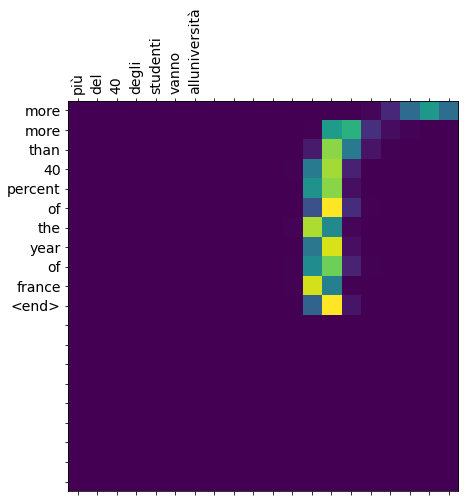

In [47]:
norm = np.linalg.norm(np.array(att))
normal_array = np.array(att)/norm
attention_plot= np.array(normal_array)
print(len(validation['italian'].iloc[i].split()))
plot_attention(attention_plot, ans, validation['italian'].iloc[i])


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [48]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
model  = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng,score_fun='general',att_units=16)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=custom_lossfunction)
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
batch_size=1024
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data= test_dataloader, validation_steps=valid_steps,callbacks=tensorboard_callback)
model.summary()

def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  encoded              = tknizer_ita.texts_to_sequences([input_sentence])
  encoded              = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=20, dtype='int',padding='post'))
  initial_state        = model.layers[0].initialize_states(batch_size=1)
  encoder_outputs, h , c = model.layers[0](encoded,initial_state)
  start                = tknizer_eng.word_index['<start>']
  output_sentence=[]
  attention_weights_list=[]
  attention_plot=np.zeros((20,20))
  for i in range(20):
   decoder_output = model.layers[1](tf.expand_dims([start],axis=1),encoder_outputs,h,c)
   output_dense,h,c,attention_weights,context_vector = model.layers[1].layers[0](tf.expand_dims([start],axis=1),encoder_outputs,h,c)
   word_index=(tf.math.argmax(decoder_output[0][0]))
   attention_weights = tf.reshape(attention_weights, (1,20))
   attention_plot[i]=(attention_weights.numpy()[0])
   english_word=tknizer_eng.index_word[word_index.numpy()]
   start=word_index.numpy()
   output_sentence.append(english_word)
   if english_word=='<end>':
     break
  return " ".join(output_sentence),attention_plot

Bleu=[]
print(len(validation['italian']))
for i in np.random.choice(np.arange(len(validation['italian'])),size=1000,replace=False):
  ans,att=predict(validation['italian'].iloc[i])
  Bleu.append(nltk.translate.bleu_score.sentence_bleu(validation['english_out'].iloc[i],ans))
print(sum(Bleu)/1000)


for i in np.random.choice(np.arange(len(validation['italian'])),size=10,replace=False):
  ans,att=predict(validation['italian'].iloc[i])
  print('Italian\t',validation['italian'].iloc[i])
  print('English_out\t',validation['english_out'].iloc[i])
  print('Predicted\t',ans)
  print('\n')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
268/268 [==============================] - 209s 780ms/step - loss: 2.0704 - val_loss: 1.6700
Epoch 2/30
268/268 [==============================] - 209s 778ms/step - loss: 1.6584 - val_loss: 1.5848
Epoch 3/30
268/268 [==============================] - 208s 777ms/step - loss: 1.5486 - val_loss: 1.3853
Epoch 4/30
268/268 [==============================] - 209s 780ms/step - loss: 1.3240 - val_loss: 1.1586
Epoch 5/30
268/268 [==============================] - 210s 782ms/step - loss: 1.1054 - val_loss: 0.9922
Epoch 6/30
268/268 [==============================] - 210s 784ms/step - loss: 0.9454 - val_loss: 0.8699
Epoch 7/30
268/268 [==============================] - 209s 780ms/step - loss: 0.8204 - val_loss: 0.7618
Epoch 8/30
268/268 [==============================] - 210s 783ms/step - loss: 0.7034 - val_loss: 0.6622
Epoch 9/30
268/268 [==============================] - 210s 783ms/step - loss: 0.5993 - val_loss: 0.5785
Epoch 10/30
268/268 [==============================] - 207s 775m

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.8371574954566796
Italian	 devo andare a fare la spesa tornerò tra unora
English_out	 i have to go shopping i will be back in an hour <end>
Predicted	 i have to go shopping i am back to a couple <end>


Italian	 hai dei fratelli
English_out	 do you have any brothers <end>
Predicted	 do you have any brothers <end>


Italian	 hai corso alcuni rischi non necessari
English_out	 you took some unnecessary risks <end>
Predicted	 you took some unnecessary risks <end>


Italian	 tom minacciò mary con la sua pistola
English_out	 tom threatened mary with his gun <end>
Predicted	 tom threatened mary with his hat <end>


Italian	 io amo i panda
English_out	 i love pandas <end>
Predicted	 i love pandas <end>


Italian	 tom divenne un tossicodipendente
English_out	 tom became a drug addict <end>
Predicted	 tom became a drug addict <end>


Italian	 non darlo a tom
English_out	 do not give it to tom <end>
Predicted	 do not give tom that <end>


Italian	 lei non piace a tom e mary
English_out	 tom and 

5


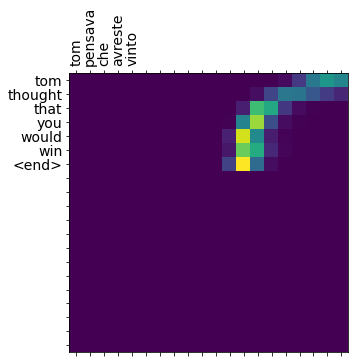

In [49]:
norm = np.linalg.norm(np.array(att))
normal_array = np.array(att)/norm
attention_plot= np.array(normal_array)
print(len(validation['italian'].iloc[i].split()))
plot_attention(attention_plot, ans, validation['italian'].iloc[i])


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [50]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
model  = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng,score_fun='concat',att_units=16)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=custom_lossfunction)
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
batch_size=1024
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data= test_dataloader, validation_steps=valid_steps,callbacks=tensorboard_callback)
model.summary()
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  encoded              = tknizer_ita.texts_to_sequences([input_sentence])
  encoded              = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=20, dtype='int',padding='post'))
  initial_state        = model.layers[0].initialize_states(batch_size=1)
  encoder_outputs, h , c = model.layers[0](encoded,initial_state)
  start                = tknizer_eng.word_index['<start>']
  output_sentence=[]
  attention_weights_list=[]
  attention_plot=np.zeros((20,20))
  for i in range(20):
   decoder_output = model.layers[1](tf.expand_dims([start],axis=1),encoder_outputs,h,c)
   output_dense,h,c,attention_weights,context_vector = model.layers[1].layers[0](tf.expand_dims([start],axis=1),encoder_outputs,h,c)
   word_index=(tf.math.argmax(decoder_output[0][0]))
   attention_weights = tf.reshape(attention_weights, (1,20))
   attention_plot[i]=(attention_weights.numpy()[0])
   english_word=tknizer_eng.index_word[word_index.numpy()]
   start=word_index.numpy()
   output_sentence.append(english_word)
   if english_word=='<end>':
     break
  return " ".join(output_sentence),attention_plot

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
268/268 [==============================] - 212s 791ms/step - loss: 2.0702 - val_loss: 1.6613
Epoch 2/30
268/268 [==============================] - 212s 790ms/step - loss: 1.6319 - val_loss: 1.5096
Epoch 3/30
268/268 [==============================] - 211s 788ms/step - loss: 1.4614 - val_loss: 1.3047
Epoch 4/30
268/268 [==============================] - 210s 782ms/step - loss: 1.2641 - val_loss: 1.1514
Epoch 5/30
268/268 [==============================] - 212s 792ms/step - loss: 1.1102 - val_loss: 1.0231
Epoch 6/30
268/268 [==============================] - 211s 787ms/step - loss: 0.9781 - val_loss: 0.9016
Epoch 7/30
268/268 [==============================] - 211s 786ms/step - loss: 0.8528 - val_loss: 0.7974
Epoch 8/30
268/268 [==============================] - 212s 790ms/step - loss: 0.7440 - val_loss: 0.7054
Epoch 9/30
268/268 [==============================] - 212s 792ms/step - loss: 0.6489 - val_loss: 0.6286
Epoch 10/30
268/268 [==============================] - 211s 789m

In [51]:
Bleu=[]
print(len(validation['italian']))
for i in np.random.choice(np.arange(len(validation['italian'])),size=1000,replace=False):
  ans,att=predict(validation['italian'].iloc[i])
  Bleu.append(nltk.translate.bleu_score.sentence_bleu(validation['english_out'].iloc[i],ans))
print(sum(Bleu)/1000)

for i in np.random.choice(np.arange(len(validation['italian'])),size=10,replace=False):
  ans,att=predict(validation['italian'].iloc[i])
  print('Italian\t',validation['italian'].iloc[i])
  print('English_out\t',validation['english_out'].iloc[i])
  print('Predicted\t',ans)
  print('\n')

68678


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.835481795830919
Italian	 ha perseguito la sua carriera a spese della sua famiglia
English_out	 he pursued his career at the expense of his family <end>
Predicted	 he pursued his career at the expense of his family <end>


Italian	 pianse
English_out	 she cried <end>
Predicted	 he cried <end>


Italian	 io non voglio più combattere
English_out	 i do not want to fight anymore <end>
Predicted	 i do not want to fight anymore <end>


Italian	 devi rispondere alla lettera
English_out	 you have to reply to the letter <end>
Predicted	 you have to reply to the letter <end>


Italian	 sembrava un dottore
English_out	 did he look like a doctor <end>
Predicted	 he looked like a doctor <end>


Italian	 sarà ancora qui questo pomeriggio
English_out	 will you still be here this afternoon <end>
Predicted	 are you going to be here this afternoon <end>


Italian	 non sapeva che mary era la cugina di tom
English_out	 did not you know mary was tom is cousin <end>
Predicted	 did not you know mary was you

8


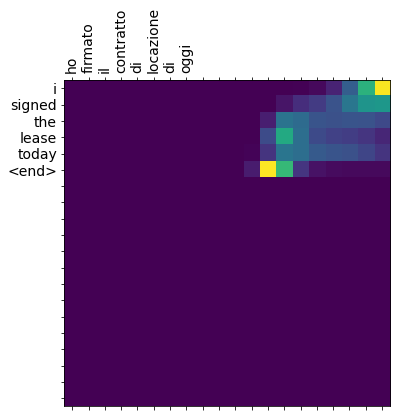

In [52]:
norm = np.linalg.norm(np.array(att))
normal_array = np.array(att)/norm
attention_plot= np.array(normal_array)
print(len(validation['italian'].iloc[i].split()))
plot_attention(attention_plot, ans, validation['italian'].iloc[i])

In [ ]:
tensorboard --logdir=./

In [54]:
# Write your observations on each of the scoring function

In [55]:
from prettytable import PrettyTable

In [57]:
t = PrettyTable(['Function','Bleu score'])
t.add_row(['Encoder_Decoder',0.834200935079292])
t.add_row(['Attention_Dot', 0.8390026045640984])
t.add_row(['Attention_General',0.8371574954566796])
t.add_row(['Attention_Concat',0.835481795830919 ])
print(t)

+-------------------+--------------------+
|      Function     |     Bleu score     |
+-------------------+--------------------+
|  Encoder_Decoder  | 0.834200935079292  |
|   Attention_Dot   | 0.8390026045640984 |
| Attention_General | 0.8371574954566796 |
|  Attention_Concat | 0.835481795830919  |
+-------------------+--------------------+
